# Informe Técnico - Exploración Tabla Usuarios

## 1. Descripción general
- Cantidad de registros: 1000
- Columnas presentes: 7

## 2. Revisión de columnas
| Columna       | Tipo de dato | Valores no nulos | Observaciones                         |
| -----------   | ------------ | ---------------- | --------------------------------------|
| UsuarioID     | int64        | 1000             | Clave primaria.                       |
| Nombre        | object       | 1000             | Texto. No hay valores faltantes.      |
| Apellido      | object       | 1000             | Texto.                                |
| email         | object       | 1000             | texto.                                |
| Contraseña    | object       | 1000             | Unidades disponibles.                 |
| FechaRegistro | datetime     | 1000             | Fecha registro de usuario, default now|

## 3. Calidad de datos
- Valores faltantes: No hay
- Valores por defecto: Fecha de registro, fecha HOY.

## 4. Principales hallazgos
- Alta tasa de conversión (usuarios que realizaron órdenes)
- Usuarios con mayor gasto acumulado es elevado y tomando en cuenta valor promedio de ordenes, sugiere muchas compras y no compras voluminosas.
- - El valor máximo observado en una orden individual es de $999,99.

- - El gasto acumulado de los usuarios top (~$30.000) indica que han realizado al menos entre 30 y 60 órdenes, si consideramos los valores promedio y máximo del total en ordenes.

- - Esto sugiere una alta recurrencia de compra entre los usuarios top
- Todos los usuarios han realizado al menos una orden.
- Todos los usuarios han dejado al menos una reseña.

## 5. Visualizaciones
- Se incluye gráfico de barras con los 10 usuarios que más han gastado.


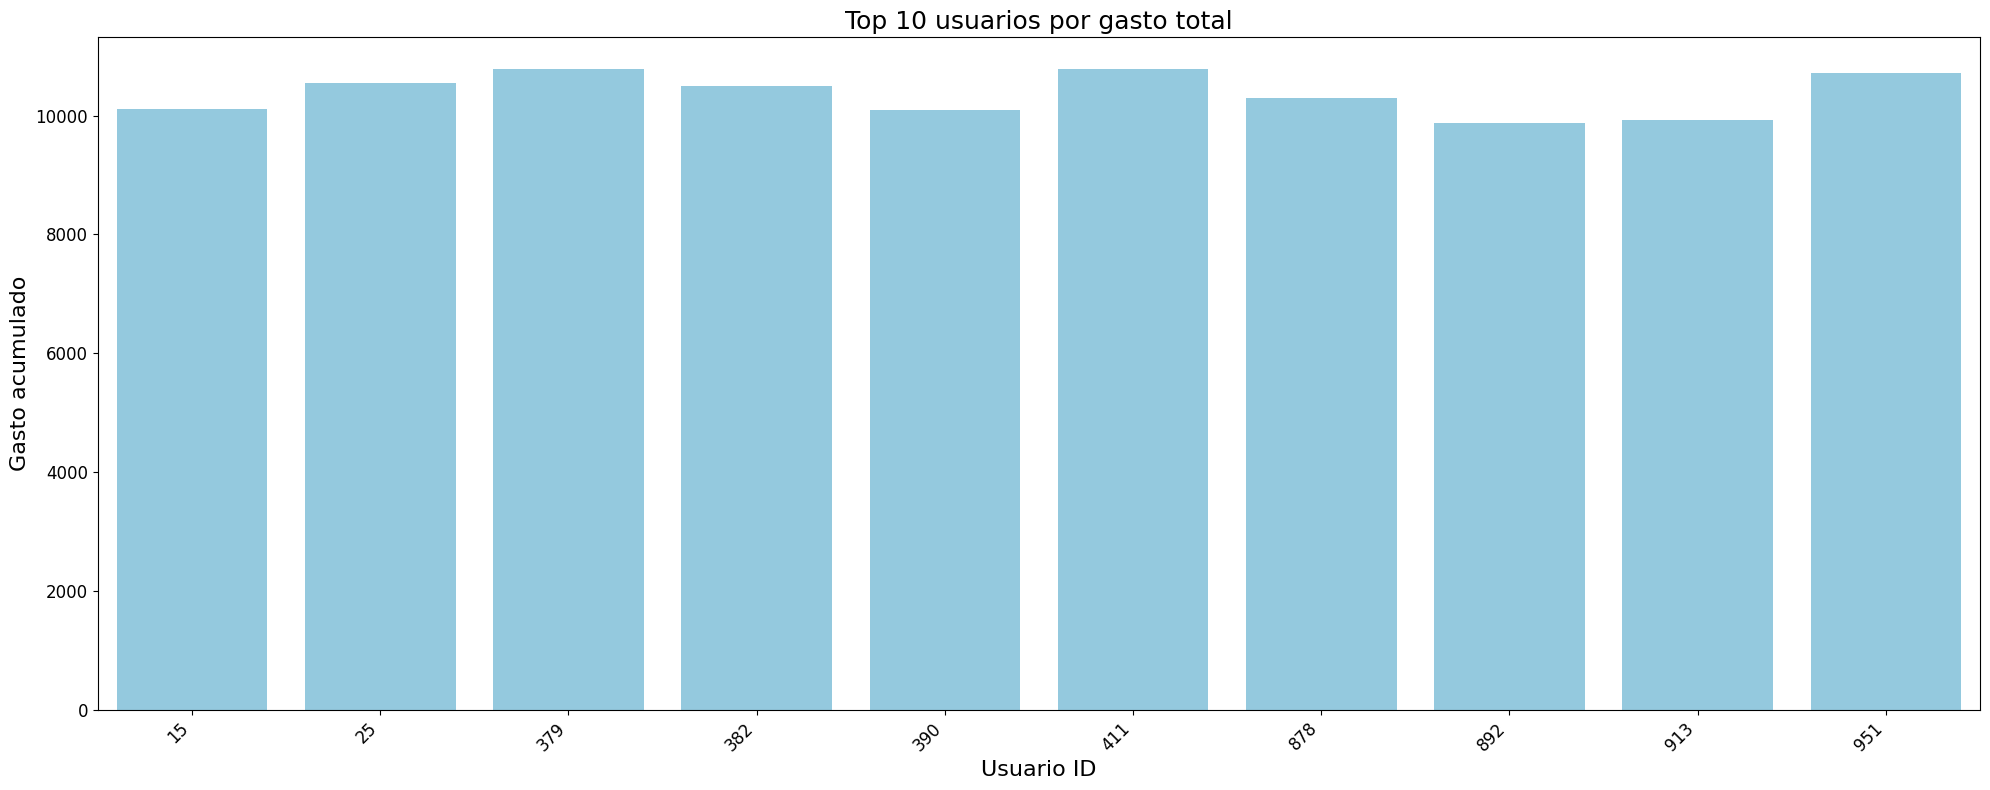

In [1]:
from app.utils import plot_utils,postgres_utils


query = """
SELECT "UsuarioID", SUM("Total") AS "GastoTotal"
FROM "Ordenes"
GROUP BY "UsuarioID"
ORDER BY "GastoTotal" DESC
LIMIT 10
"""

top_gastadores_df = postgres_utils.run_query(query)

plot_utils.plot_top_bar_chart(
    df=top_gastadores_df,
    x_column='UsuarioID',
    y_column='GastoTotal',
    plot_title="Top 10 usuarios por gasto total",
    x_label="Usuario ID",
    y_label="Gasto acumulado",
    top_n=10,
    figsize=(20, 8)
)


## 6. Decisiones tomadas
- Descartar columna `fecha_registro` del análisis temporal
- Posible estandarización de nombres a futuro
- Hashear columna contraseña por seguridad.

## 7. Consultas SQL relevantes
[Anexo](./scripts/sql/report.sql)

# Informe Técnico - Exploración Tabla Productos

## 1. Descripción general
- Cantidad de registros: 36
- Columnas presentes: 6

## 2. Revisión de columnas
| Columna     | Tipo de dato | Valores no nulos | Observaciones                      |
| ----------- | ------------ | ---------------- | ---------------------------------- |
| ProductoID  | int64        | 36               | Clave primaria.                    |
| Nombre      | object       | 36               | Texto. No hay valores faltantes.   |
| Descripcion | object       | 36               | Texto. Puede contener redundancia. |
| Precio      | float64      | 36               | Valor numérico.                    |
| Stock       | int64        | 36               | Unidades disponibles.              |
| CategoriaID | int64        | 36               | Clave foránea a `Categorias`.      |

## 3. Calidad de datos
- Valores faltantes: -
- Valores por defecto: -
- Validaciones aplicadas: Stock, Precio y Nombre no pueden ser nulos.

## 4. Principales hallazgos
- Alta dispersión en precio de productos, son pocos items (en relación al número de órdenes (10000) y de compradores (1000) con precios que oscilan entre 20 y 799).
- Si bien la variabilidad en precios puede ser habitual, debería tomarse en cuenta para el análisis de venta la presencia de los items de mayor valor.
- En los diez productos de mayor valor se encuentra el máximo de 799 y el último de 299.
- El campo Nombre no es clave primaria, pero desde una perspectiva de negocio podría esperarse que sea único. No se detectaron valores duplicados, pero no hay una restricción que lo garantice actualmente.
- Se detectó un varianza moderada en el volumen de ventas de los distintos productos, no hay casi registros con menos de 790 unidades vendidas.

In [6]:
from app.utils import notebook_utils, postgres_utils

query = """
SELECT 
    p."ProductoID",
    p."Nombre",
    p."Stock",
    COALESCE(SUM(d."Cantidad"), 0) AS total_vendido
FROM "Productos" p
LEFT JOIN "DetalleOrdenes" d ON p."ProductoID" = d."ProductoID"
GROUP BY p."ProductoID", p."Nombre", p."Stock"
HAVING COALESCE(SUM(d."Cantidad"), 0) < 790
ORDER BY p."Stock" DESC
LIMIT 10;
"""
notebook_utils.print_colored("Productos con alto stock y bajas ventas (< 790)", "green")
postgres_utils.run_query(query)


,ProductoID,Nombre,Stock,total_vendido
0,7,Sartén Antiadherente 24cm,120,693
1,11,Pelota de Fútbol Profesional,100,750
2,33,"Power Bank 20,000mAh",70,777
3,15,Plancha para Cabello Remington,70,707
4,20,Limpiaparabrisas Universal,60,777
5,12,Mochila Deportiva Nike,50,771
6,14,Perfume Hombre 100ml,40,770
7,21,Cámara de Reversa,40,777
8,10,Bicicleta Montaña Aro 29,20,757


## 5. Visualizaciones

* Se observan 15 outliers de precio por encima de 120, con uno de ellos alcanzando los 799. Esto contrasta con el resto de los productos cuyo precio ronda los 30.
* Se observan 9 outliers de stock entre 200 y 300.

Number of outliers in 'Precio': 15


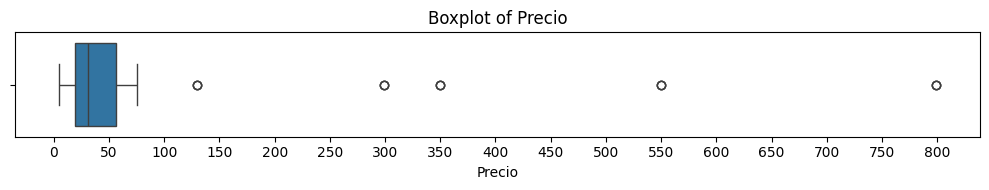

Number of outliers in 'Stock': 9


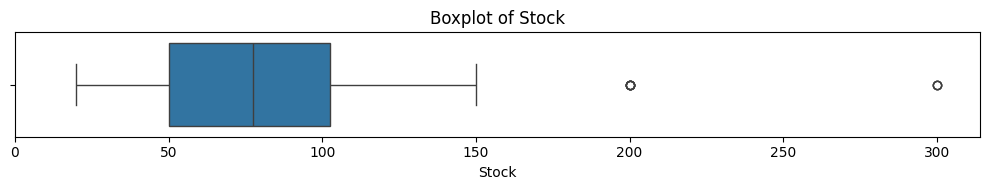

In [4]:
from app.utils import plot_utils

outliers_precio, lower_precio, upper_precio = plot_utils.plot_boxplot_with_outliers('Productos', 'Precio', step=50)

outliers_stock, lower_stock, upper_stock = plot_utils.plot_boxplot_with_outliers('Productos', 'Stock', step=50)

* Existen productos con altos niveles de stock pero sin ninguna venta registrada. El top 5 incluye Cuaderno Universitario 100h, Camiseta Básica Hombre, etc.

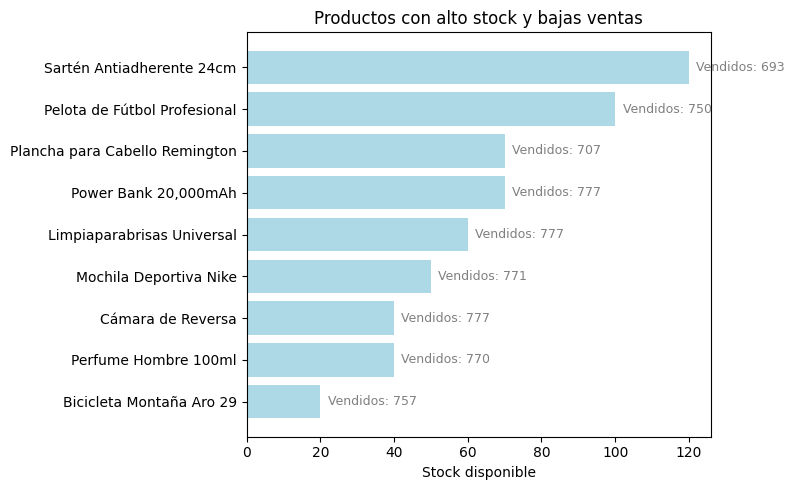

In [1]:
from app.utils import plot_utils

plot_utils.plot_high_stock_lowest_sells()



## 6. Recomendaciones
- Evaluar la necesidad de hacer único el campo Nombre, según el uso por parte del negocio.
- Aunque el campo Nombre no es clave primaria, desde el punto de vista del negocio podría requerirse unicidad para evitar confusiones. Por ejemplo, tener productos con el mismo nombre (aunque con diferente ProductoID) podría generar errores en reportes o en interfaces de usuario.
- Consultar con el área de negocio si debe garantizarse que cada producto tenga un nombre único
- Crear índice sobre Stock o Precio, dada su alta frecuencia de uso en consultas analíticas.
- Definir vistas para consultas recurrentes (por ejemplo, productos con baja rotación).
  
## 7. Consultas SQL relevantes
[Anexo](./scripts/sql/report.sql)

# Informe Técnico - Exploración Tabla Categorías

## 1. Descripción general
- Cantidad de registros: 12
- Columnas presentes: 3

## 2. Revisión de columnas
| Columna     | Tipo de dato | Valores no nulos | Observaciones                      |
| ----------- | ------------ | ---------------- | ---------------------------------- |
| CategoriaID | int64        | 12               | Clave primaria.                    |
| Nombre      | object       | 12               | Texto. No hay valores faltantes.   |
| Descripcion | object       | 12               | Texto. Puede contener redundancia. |


## 3. Calidad de datos
- Valores faltantes: -
- Valores por defecto: -
- Validaciones aplicadas: -

## 4. Principales hallazgos
- El campo nombre no es único y es de texo libre al igual que la descripción. Aunque el campo Nombre no es clave primaria, desde una perspectiva de negocio podría esperarse que sea único. Por ejemplo, tener dos categorías llamadas "Electrónica" pero con distintos CategoriaID puede resultar confuso en reportes, búsquedas o visualización en interfaces.


## 6. Recomendaciones
- Evaluar la posibilidad de agregar una restricción de unicidad: 
```sql
ALTER TABLE "Categorias" ADD CONSTRAINT unique_categoria_nombre UNIQUE ("Nombre");
```
- Limpieza/ normalización de textos :
Ejemplos:
| Original                | Propuesta normalizada   |
| ----------------------- | ----------------------- |
| " electrónica  "        | "Electrónica"           |
| "Belleza Y cuidado"     | "Belleza y Cuidado"     |
| "DEPORTES Y aire libre" | "Deportes y Aire Libre" |

No se propone análisis exploratorio adicional sobre esta tabla, ya que su principal función es referencial y ya ha sido utilizada en las agregaciones de ventas por categoría. Se recomienda únicamente asegurar su consistencia y unicidad.

# Informe Técnico - Exploración Tabla Ordenes

## 1. Descripción general
- Cantidad de registros: 1000
- Columnas presentes: 5

## 2. Revisión de columnas
| Columna    | Tipo de dato     | Valores no nulos | Observaciones                                          |
| ---------- | ---------------- | ---------------- | ------------------------------------------------------ |
| OrdenID    | `int64`          | 10,000           | Clave primaria.                                        |
| UsuarioID  | `int64`          | 10,000           | Clave foránea a `Usuarios`.                            |
| FechaOrden | `datetime64[ns]` | 10,000           | Fecha en que se realizó la orden.                      |
| Total      | `float64`        | 10,000           | Monto total en la orden.                               |
| Estado     | `object`         | 10,000           | Estado de la orden (ej. 'Pendiente', 'Completada').    |

## 3. Calidad de datos
- Valores faltantes: -
- Valores por defecto: -
- Validaciones aplicadas: Total no puede ser nulo y por default 'Estado' es pendiente

## 4. Principales hallazgos
- Aunque el monto total de las órdenes presenta alta dispersión, su distribución es simétrica, lo cual sugiere un balance entre productos económicos y costosos en las ventas."
- No hay categorias con marcado nivel deventas, por el contrario entre los primeros 10 productos cada uno es de diferentes categorias con lo cual no hay competencia a nivel categorias.
- Los dias de mayor venta son en fin de semana y Lunes 
- El volumen de ventas mensual es uniforme (alrededor de 800 órdenes por mes) a partir de agosto. En julio se registraron apenas 25 órdenes, lo que sugiere que puede tratarse del mes de inicio del negocio o del registro de datos. Sería interesante confirmarlo.

## 5. Visualizaciones


Se muestra distribución en importe de ordenes, la media está en torno a 500.

Number of outliers in 'Total': 0


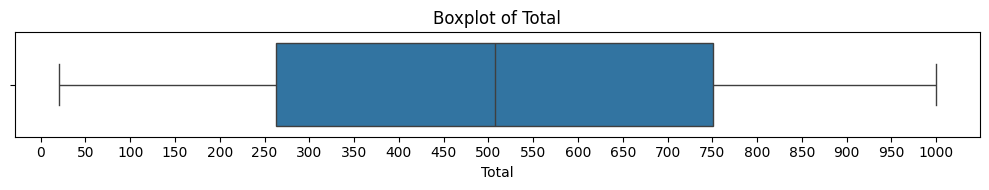

In [2]:
from app.utils import plot_utils

outliers_total, lower_total, upper_total = plot_utils.plot_boxplot_with_outliers('Ordenes', 'Total', step=50)

Prductos mas vendidos con sus categorias

In [3]:
from app.utils import postgres_utils, notebook_utils

query= """
SELECT 
    p."ProductoID",
    p."Nombre",
    SUM(d."Cantidad") AS total_vendido
FROM "Productos" p
RIGHT JOIN "DetalleOrdenes" d ON p."ProductoID" = d."ProductoID"
GROUP BY p."ProductoID", p."Nombre"
ORDER BY total_vendido DESC
LIMIT 10;
"""
notebook_utils.print_colored("Productos más vendidos por volumen", "green")
postgres_utils.run_query(query)

,ProductoID,Nombre,total_vendido
0,18,Juego de Mesa Monopoly,942
1,34,Consola PlayStation 5,935
2,26,Termómetro Digital,898
3,31,Smartwatch Xiaomi Mi Band 8,887
4,5,Jeans Skinny Mujer,887
5,32,Mini Proyector LED,885
6,23,Cuaderno Universitario 100h,876
7,29,Arenero para Gato,874
8,4,Camiseta Básica Hombre,868
9,24,Set de Lápices de Colores,856



## 6. Recomendaciones
- La columna Estado contiene valores categóricos ('Pendiente', 'Completada', 'Cancelada', 'Enviada'). Se recomienda extraer estos estados a una tabla aparte y establecer una relación mediante clave foránea.
Esto permitiría:

- - Normalizar la base de datos y reducir redundancias.

- - Evitar errores de escritura o inconsistencias en los valores.

- - Facilitar futuras extensiones (por ejemplo, incorporar nuevos estados con metadatos adicionales).

- - Mejorar la integridad referencial y la trazabilidad en el análisis de las órdenes.

  
## 7. Consultas SQL relevantes
[Anexo](./scripts/sql/report.sql)

# Informe Técnico - Exploración Tabla Usuarios

## 1. Descripción general
- Cantidad de registros: ...
- Columnas presentes: ...

## 2. Revisión de columnas
| Columna | Tipo | Descripción | Observaciones |
|--------|------|-------------|----------------|

## 3. Calidad de datos
- Valores faltantes: ...
- Valores por defecto: ...
- Validaciones aplicadas: ...

## 4. Principales hallazgos
- Alta tasa de conversión (usuarios que realizaron órdenes)
- Usuarios con mayor gasto acumulado
- Posibles problemas con duplicados en emails

## 5. Visualizaciones
(incluir gráficos exportados del EDA)

## 6. Decisiones tomadas
- Descartar columna `fecha_registro` del análisis temporal
- Posible estandarización de nombres a futuro
- Validar unicidad de `Email`

## 7. Consultas SQL relevantes
[Anexo](./scripts/sql/report.sql)